In [1]:
import cmdstanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
from hashlib import md5
import json
import arviz as az
import sys
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer

In [2]:
y_data = pd.read_csv(os.path.realpath("data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("data/engine_index.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]


In [3]:
engine_count = np.max(engine_data["engine"])
ship_count = np.max(ship_data["ship"])
max_age = np.max(age_data["age"])
data_count = y_data.shape[0]
engine_count, ship_count, max_age, data_count

(5, 99, 31, 653)

# gaussian process model

In [4]:
gp_model_dir = "gaussianprocess/models/hier_gp_weak/hier_gp_weak.stan"
gp_model = CmdStanModel(stan_file=gp_model_dir) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/gaussianprocess/models/hier_gp_weak/hier_gp_weak


In [5]:
data = {
    "N": int(data_count),
    "N_engines": int(engine_count),
    "N_ships": int(ship_count),
    "N_ages_obs": int(max_age),
    "N_ages": int(max_age),
    "ship_engine_ind": ship_engine_mapping_data["engine"].values.tolist(),
    "ship_ind": ship_data["ship"].values.tolist(),
    "age_ind": age_data["age"].values.tolist(),
    "y": y_data["y"].values.tolist(),
}

In [6]:
%%time
gp_model_fit = gp_model.sample(chains=4, cores=4, data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


CPU times: user 1 s, sys: 103 ms, total: 1.11 s
Wall time: 1min 46s


In [7]:
gp_model_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpmdzmlakd/hier_gp_weak-202008221352-1-x20jhvxc.csv, /tmp/tmpmdzmlakd/hier_gp_weak-202008221352-2-7p6cihfl.csv, /tmp/tmpmdzmlakd/hier_gp_weak-202008221352-3-iq783e_f.csv, /tmp/tmpmdzmlakd/hier_gp_weak-202008221352-4-kzqaaoow.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 4000 (0.025%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


"Processing csv files: /tmp/tmpmdzmlakd/hier_gp_weak-202008221352-1-x20jhvxc.csv, /tmp/tmpmdzmlakd/hier_gp_weak-202008221352-2-7p6cihfl.csv, /tmp/tmpmdzmlakd/hier_gp_weak-202008221352-3-iq783e_f.csv, /tmp/tmpmdzmlakd/hier_gp_weak-202008221352-4-kzqaaoow.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n1 of 4000 (0.025%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete."

In [8]:
gp_az_inference = az.from_cmdstanpy(gp_model_fit, posterior_predictive="obs_mu", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# spline model

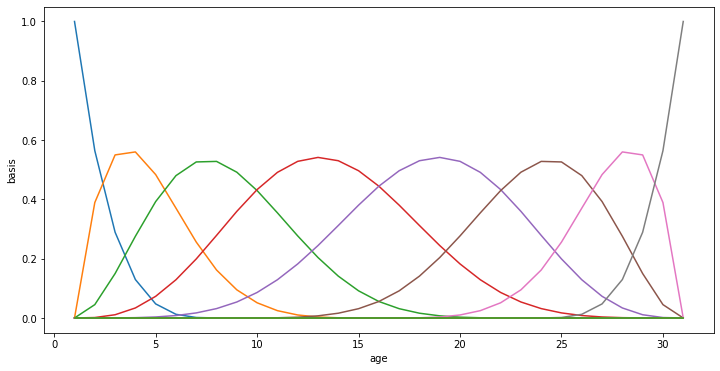

In [9]:
degree = 4
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [10]:
basis_df.shape

(31, 13)

In [11]:
spline_model_file = os.path.join('spline/models','layer3_nc_diffsd_parammubar.stan')
layer3_model = CmdStanModel(stan_file=spline_model_file) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/models/layer3_nc_diffsd_parammubar


In [12]:
data = {
    "K" : basis_df.shape[1],
    "N" : int(data_count),  # number of total values
    "T" : int(max_age),  # length of time of data(31)
    "S" : int(ship_count), #failure_df.shape[1],  # number of ships(99)
    "E" : int(engine_count),  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": int(data_count),
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [13]:
%%time
spline_model_fit = layer3_model.sample(chains=4, cores=4, data=data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


CPU times: user 527 ms, sys: 48.9 ms, total: 576 ms
Wall time: 2min 28s


In [14]:
spline_model_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpmdzmlakd/layer3_nc_diffsd_parammubar-202008221354-1-lctg5i8s.csv, /tmp/tmpmdzmlakd/layer3_nc_diffsd_parammubar-202008221354-2-s7ku5lej.csv, /tmp/tmpmdzmlakd/layer3_nc_diffsd_parammubar-202008221354-3-qwiqa2a4.csv, /tmp/tmpmdzmlakd/layer3_nc_diffsd_parammubar-202008221354-4-i2c_tnud.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
19 of 4000 (0.47%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


"Processing csv files: /tmp/tmpmdzmlakd/layer3_nc_diffsd_parammubar-202008221354-1-lctg5i8s.csv, /tmp/tmpmdzmlakd/layer3_nc_diffsd_parammubar-202008221354-2-s7ku5lej.csv, /tmp/tmpmdzmlakd/layer3_nc_diffsd_parammubar-202008221354-3-qwiqa2a4.csv, /tmp/tmpmdzmlakd/layer3_nc_diffsd_parammubar-202008221354-4-i2c_tnud.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n19 of 4000 (0.47%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete."

In [15]:
#pd.set_option('display.max_rows', None)
spline_model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-414.172000,0.511801,17.133500,-443.236000,-413.886000,-386.712000,1120.69,4.01695,1.002870
mu_a_bar,-0.066793,0.013311,0.854905,-1.486730,-0.070870,1.367230,4124.70,14.78430,0.999935
mu_w_bar[1],-1.124150,0.009126,0.498057,-1.952310,-1.123690,-0.310856,2978.82,10.67710,1.001730
mu_w_bar[2],0.822756,0.009212,0.520070,-0.029225,0.824109,1.680860,3187.12,11.42370,1.000980
mu_w_bar[3],0.332069,0.010253,0.617865,-0.687144,0.340090,1.361700,3631.20,13.01550,1.000020
...,...,...,...,...,...,...,...,...,...
y_new_pred[649],2.177500,0.012461,0.825185,0.811645,2.166320,3.518710,4385.09,15.71770,0.999240
y_new_pred[650],0.512120,0.013910,0.859032,-0.898484,0.524137,1.922890,3813.56,13.66910,1.000600
y_new_pred[651],0.723171,0.013628,0.861757,-0.693670,0.722354,2.145920,3998.72,14.33280,0.999870


In [16]:
spline_az_inference = az.from_cmdstanpy(spline_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# check out arviz stuff

In [17]:
gp_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [18]:
spline_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [19]:
az.loo(gp_az_inference, pointwise=True)

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -790.34    18.21
p_loo      123.56        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      617   94.5%
 (0.5, 0.7]   (ok)         31    4.7%
   (0.7, 1]   (bad)         5    0.8%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [20]:
az.loo(spline_az_inference, pointwise=True)

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 653 log-likelihood matrix

         Estimate       SE
elpd_loo  -801.51    18.80
p_loo       94.51        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      632   96.8%
 (0.5, 0.7]   (ok)         15    2.3%
   (0.7, 1]   (bad)         5    0.8%
   (1, Inf)   (very bad)    1    0.2%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [21]:
import logging
logger=  logging.getLogger()
logger.setLevel(logging.DEBUG)
comp = az.compare({"gaussian_process": gp_az_inference, "spline": spline_az_inference}, ic="loo")
comp

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
gaussian_process,0,-790.338,123.559,0,0.945457,18.5423,0,True,log
spline,1,-801.507,94.5105,11.1695,0.0545433,19.4857,7.1657,True,log


In [22]:
spline_yhat = np.mean(spline_model_fit.get_drawset(params=["y_new_pred"]), axis=0).values

In [23]:
gp_yhat = np.mean(gp_model_fit.get_drawset(params=["obs_mu"]), axis=0).values

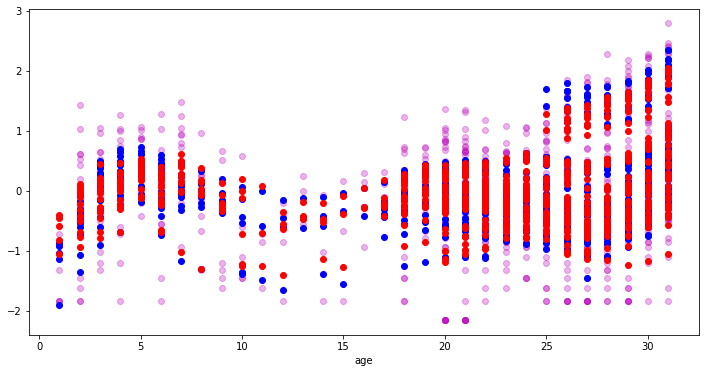

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, spline_yhat, color="blue", linewidth=1)
ax.scatter(age_data, gp_yhat, color="r", linewidth=1)

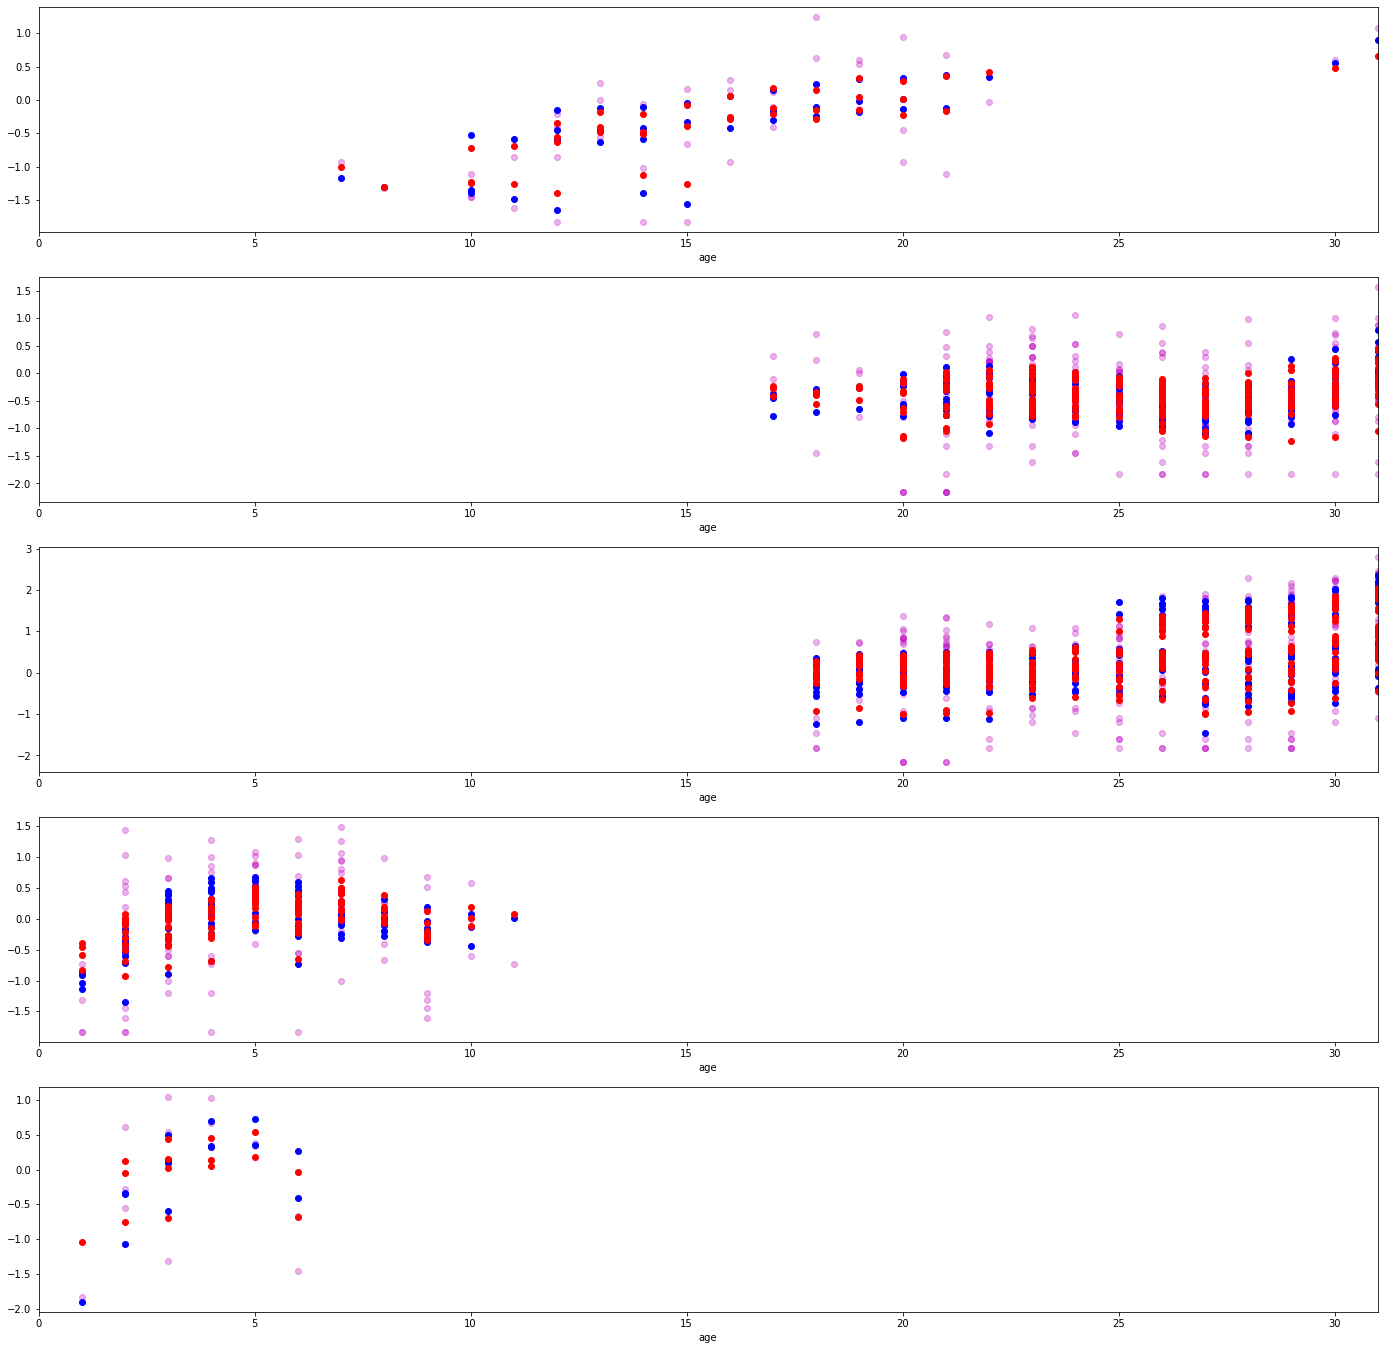

In [25]:
fig, ax = plt.subplots(engine_count,1, figsize=(24, 24))

for x in range(1, engine_count+1):
    ax[x-1].set_xlabel('age')
    ax[x-1].set_xlim(0, 31) 
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], y_data["y"].values[engine_data["engine"].values == x], color='m', alpha=0.3)
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], spline_yhat[engine_data["engine"].values == x], color="blue")
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], gp_yhat[engine_data["engine"].values == x], color="r")

In [26]:
mean_squared_error(spline_yhat, y_data["y"].values)

0.4877897726225007

In [27]:
mean_squared_error(gp_yhat, y_data["y"].values)

0.4259769258310188

# stack em up

In [28]:
stacked_yhat = np.dot(np.transpose(np.vstack([gp_yhat, spline_yhat])), comp.weight.values)

In [29]:
mean_squared_error(stacked_yhat, y_data["y"].values)

0.42744345752071444

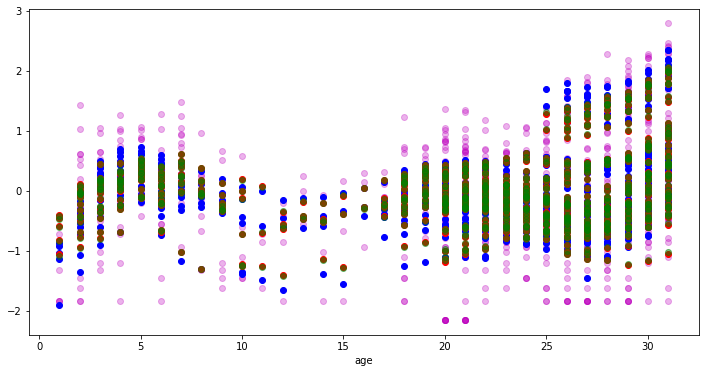

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, spline_yhat, color="blue", linewidth=1)
ax.scatter(age_data, gp_yhat, color="r", linewidth=1)
ax.scatter(age_data, stacked_yhat, color="green", linewidth=1, alpha=0.5)

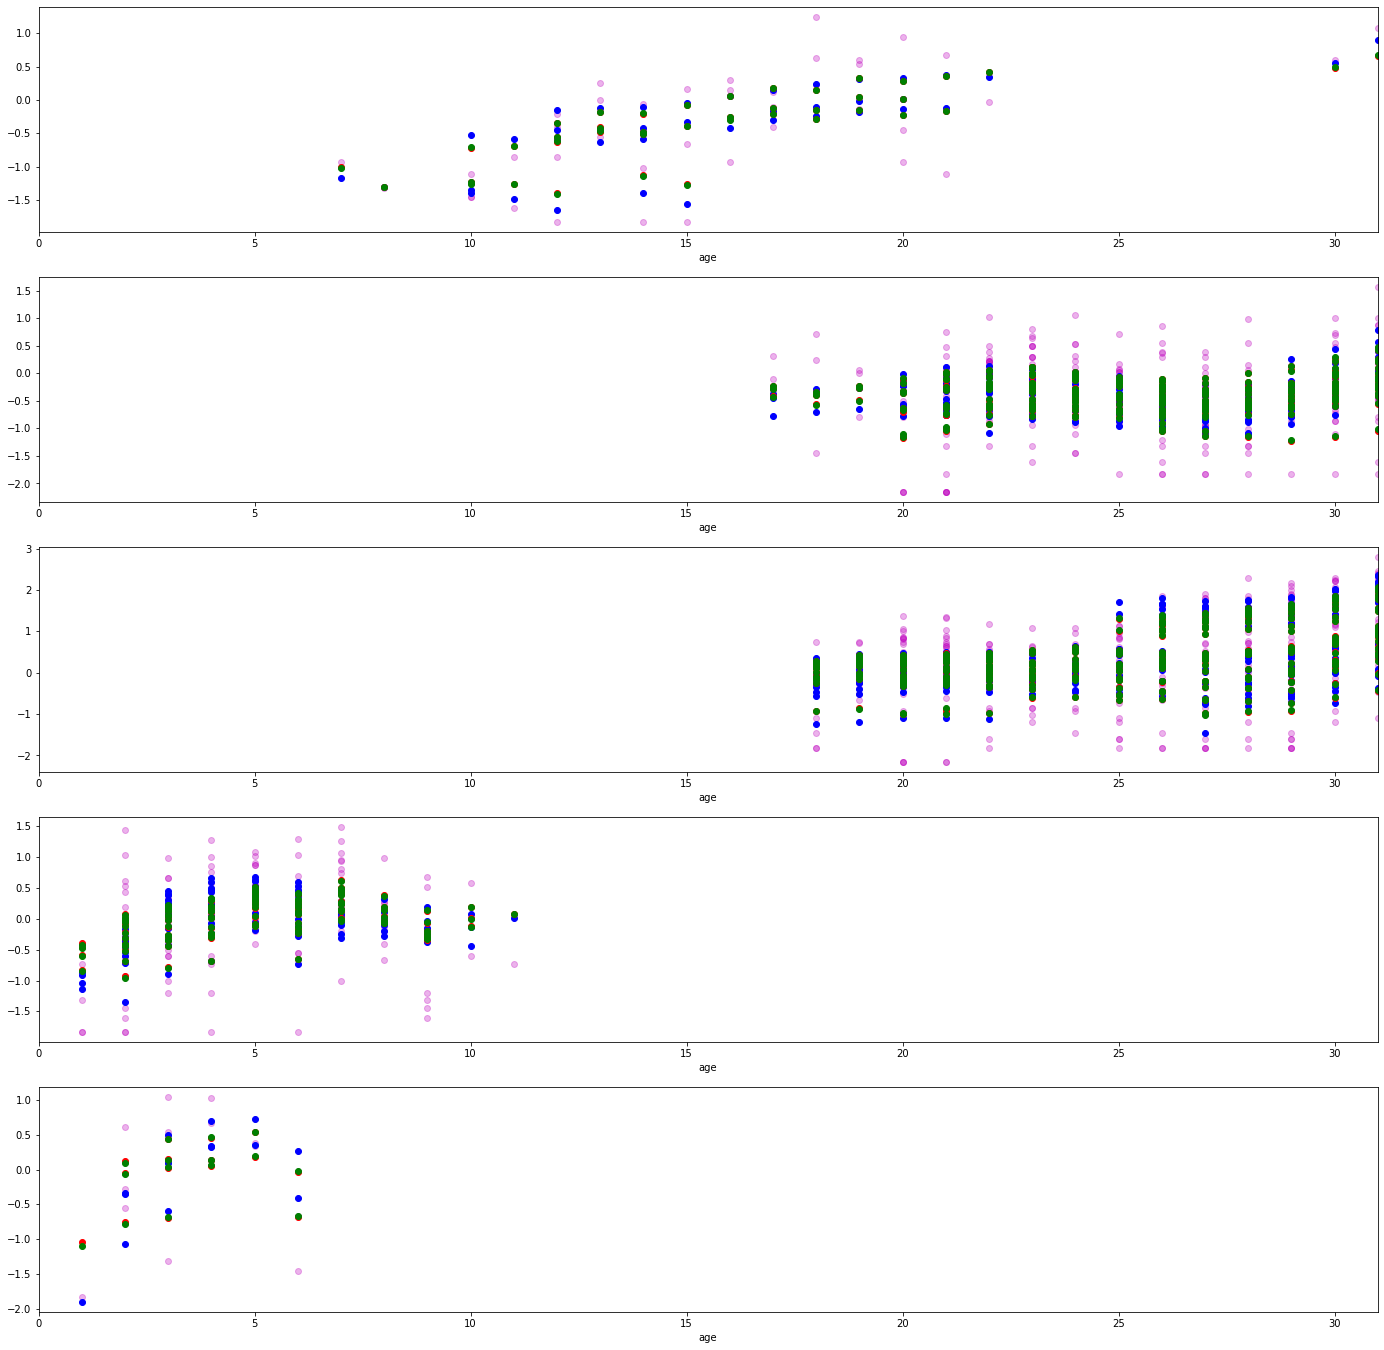

In [31]:
fig, ax = plt.subplots(engine_count,1, figsize=(24, 24))

for x in range(1, engine_count+1):
    ax[x-1].set_xlabel('age')
    ax[x-1].set_ylabel('failure count')
    ax[x-1].set_xlim(0, 31) 
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], y_data["y"].values[engine_data["engine"].values == x], color='m', alpha=0.3)
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], spline_yhat[engine_data["engine"].values == x], color="blue")
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], gp_yhat[engine_data["engine"].values == x], color="r")
    ax[x-1].scatter(age_data["age"].values[engine_data["engine"].values == x], stacked_yhat[engine_data["engine"].values == x], color="green")